In [1]:
import numpy as np
import cv2
import os

In [2]:
PATH = 'C:/Users/Lenovo/Desktop/New folder/python/openCV/Text Detection/myData'
myList = os.listdir(PATH)
myList

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [3]:
# Total number of classes detected
len(myList)

10

In [4]:
nClasses = len(myList)
images = []
classNo = []
for x in range(nClasses):
    myPicList = os.listdir(PATH + '/' + str(x))
    for y in myPicList:
        curImg = cv2.imread(PATH + '/' + str(x) + "/" + y)
        curImg = cv2.resize(curImg, (32, 32))
        images.append(curImg)
        classNo.append(x)

In [5]:
len(images)

10160

In [6]:
len(classNo)

10160

In [7]:
# Convert list to numpy array and check shape
images = np.array(images)
classNo = np.array(classNo)

print(images.shape)
print(classNo.shape)

(10160, 32, 32, 3)
(10160,)


### Splitting the data into training, testing and validation

In [8]:
from sklearn.model_selection import train_test_split
testRatio = 0.2

X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)

In [9]:
X_train.shape

(8128, 32, 32, 3)

In [10]:
X_test.shape

(2032, 32, 32, 3)

In [11]:
validationRatio = 0.2
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

In [12]:
X_validation.shape

(1626, 32, 32, 3)

### Check Distribution of Images for each Class

In [13]:
no_of_samples = []
for i in range(nClasses):
    # print(len(np.where(y_train==i)[0]))
    no_of_samples.append(len(np.where(y_train==i)[0]))
print(no_of_samples)

[650, 655, 628, 653, 658, 626, 656, 661, 683, 632]


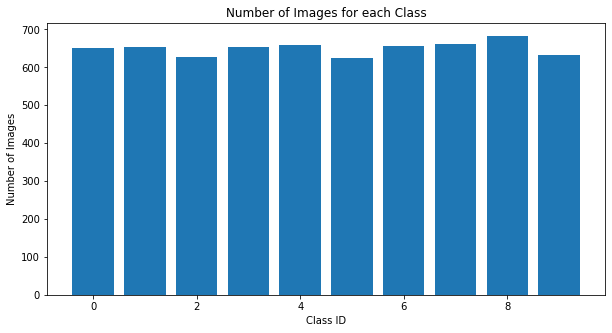

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(range(nClasses), no_of_samples)
plt.title("Number of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

### Preprocessing of Images

In [15]:
X_train[30].shape

(32, 32, 3)

In [16]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img / 255
    return img

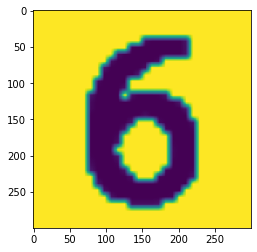

In [17]:
img = preprocess(X_train[30])
img = cv2.resize(img, (300, 300))
plt.imshow(img)

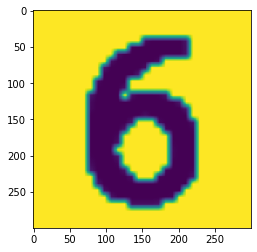

In [18]:
# Preprocess all the images in X_train
X_train = np.array(list(map(preprocess, X_train)))
img = X_train[30]
img = cv2.resize(img, (300, 300))
plt.imshow(img)

In [19]:
X_train[30].shape

(32, 32)

In [20]:
X_test = np.array(list(map(preprocess, X_test)))
X_validation = np.array(list(map(preprocess, X_validation)))

In [21]:
X_train.shape

(6502, 32, 32)

In [22]:
# Add depth of 1 to the images for CNN to run properly
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)

In [23]:
X_train.shape

(6502, 32, 32, 1)

### Apply Image Augmentation to make Dataset more generic

In [24]:
from keras.preprocessing.image import ImageDataGenerator

dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range = 10)

dataGen.fit(X_train)

In [26]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, nClasses)
y_validation = to_categorical(y_validation, nClasses)
y_test = to_categorical(y_test, nClasses)

### Create the Neural Network Model

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [29]:
imageDimensions = (32, 32, 3)

def myModel():
    noOfFilters = 60
    sizeOfFilters = (5, 5)
    sizeOfFilters_2 = (3, 3)
    sizeOfPool = (2, 2)
    no_of_nodes = 500
    
    model = Sequential()
    model.add((Conv2D(noOfFilters, sizeOfFilters, input_shape=(imageDimensions[0], imageDimensions[1], 1), activation="relu")))
    model.add((Conv2D(noOfFilters, sizeOfFilters, activation="relu")))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilters_2, activation="relu")))
    model.add((Conv2D(noOfFilters//2, sizeOfFilters_2, activation="relu")))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(no_of_nodes, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation="softmax"))
    
    model.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
    return model

In [30]:
model = myModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

In [32]:
batch_size_val = 50
epoch_val = 10
steps_per_epoch_val = 2000

history = model.fit_generator(dataGen.flow(X_train, y_train,
                                 batch_size = batch_size_val),
                    epochs = epoch_val,
                    validation_data = (X_validation, y_validation),
                    shuffle = 1)

Epoch 1/10
131/131 [==============================] - 40s 307ms/step - loss: 0.4770 - accuracy: 0.8460 - val_loss: 0.0988 - val_accuracy: 0.9723
Epoch 2/10
131/131 [==============================] - 40s 305ms/step - loss: 0.3280 - accuracy: 0.8942 - val_loss: 0.0862 - val_accuracy: 0.9803
Epoch 3/10
131/131 [==============================] - 43s 329ms/step - loss: 0.2695 - accuracy: 0.9110 - val_loss: 0.0519 - val_accuracy: 0.9865
Epoch 4/10
131/131 [==============================] - 43s 326ms/step - loss: 0.2358 - accuracy: 0.9254 - val_loss: 0.0463 - val_accuracy: 0.9926
Epoch 5/10
131/131 [==============================] - 41s 310ms/step - loss: 0.1817 - accuracy: 0.9425 - val_loss: 0.0322 - val_accuracy: 0.9920
Epoch 6/10
131/131 [==============================] - 44s 333ms/step - loss: 0.1741 - accuracy: 0.9408 - val_loss: 0.0291 - val_accuracy: 0.9926
Epoch 7/10
131/131 [==============================] - 45s 342ms/step - loss: 0.1659 - accuracy: 0.9462 - val_loss: 0.0363 - val_ac

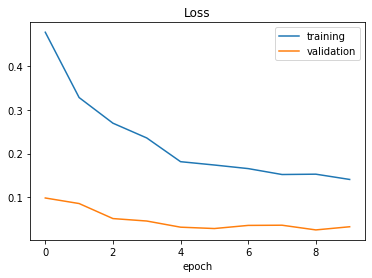

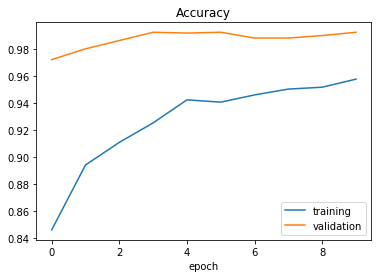

In [33]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title("Loss")
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title("Accuracy")
plt.xlabel('epoch')

plt.show()

In [34]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score: ", score[0])
print("Test Accuract: ", score[1])

Test Score:  0.025151297450065613
Test Accuract:  0.9916338324546814


In [35]:
model.save(r"C:\Users\Lenovo\Desktop\New folder\python\openCV\Text Detection\model_trained.h5")